<a href="https://colab.research.google.com/github/MrSaeidSeyfi/Saliency-based-Multi-Feature-Modeling/blob/main/SMFM_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title SIFT Implementation
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

####################
# Global variables #
####################

logger = logging.getLogger(__name__)
float_tolerance = 1e-7

#################
# Main function #
#################

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

#########################
# Image pyramid related #
#########################

def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images, dtype=object)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images, dtype=object)

###############################
# Scale-space extrema related #
###############################

def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

#########################
# Keypoint orientations #
#########################

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

##############################
# Duplicate keypoint removal #
##############################

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

#############################
# Keypoint scale conversion #
#############################

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

#########################
# Descriptor generation #
#########################

def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')
 

In [2]:
#@title disjoint
# disjoint-set forests using union-by-rank and path compression(sort of)
class Uni_elt:
    def __init__(self,rank=0,p=0,size=0):
        self.rank= rank
        self.p = p
        self.size = size

class Universe:
    def __init__(self,elements):
        self.num = elements
        self.elts = [Uni_elt(rank=0,p=i,size=1) for i in range(elements)]

    def join(self,x,y):
        if(self.elts[x].rank > self.elts[y].rank):
            self.elts[y].p = x
            self.elts[x].size += self.elts[y].size
        else:
            self.elts[x].p = y
            self.elts[y].size += self.elts[x].size
            if self.elts[x].rank == self.elts[y].rank:
                self.elts[y].rank += 1
        self.num -= 1
    def size(self,x):
        return self.elts[x].size

    def nu_sets(self):
        return self.num

    def find(self,x):
        y = x
        while(y != self.elts[y].p):
            y = self.elts[y].p
        self.elts[x].p = y
        return y



Segment graph

In [3]:
#@title Segment graph
class Edge:
    def __init__(self,w=0.0,a=0,b=0):
        self.w = w
        self.a = a
        self.b = b


def threshold(size,c):
    return c / size

"""
Segment a graph
Returns a disjoint-set forest representing the segmentation
nu_vertices:number of vertices in the graph
nu_edges: number of edges in the graph
c: constant for threshold function
"""
def  segment_graph(nu_vertices,nu_edges,edges,c):
    tmp = edges[:nu_edges]
    #sorted by weight
    tmp.sort(key=lambda edge: edge.w)
    edges[:nu_edges] = tmp
    #make a disjoint-set forest
    u = Universe(nu_vertices)
    thresholds = [threshold(1,c) for _ in range(nu_vertices)]
    loop_range= range(nu_edges)
    for i in loop_range:
        edge = edges[i]
        a = u.find(edge.a)
        b = u.find(edge.b)
        if a != b:
            if edge.w <= thresholds[a] and edge.w <= thresholds[b]:
                u.join(a,b)
                a = u.find(a)
                thresholds[a] = edge.w + threshold(u.size(a),c)
    return u

Segment image

In [4]:
#@title segment image
import cv2
import numpy as np
from math import sqrt,pow
# dissimilarity measure between pixels
def diff(img3f,x1,y1,x2,y2):
    p1 = img3f[y1,x1]
    p2 = img3f[y2,x2]
    return np.sqrt(np.sum(np.power(p1-p2,2)))

def SegmentImage(src3f,imgInd,sigma=0.5,c=200,min_size=50):
    width = src3f.shape[1]
    height = src3f.shape[0]
    smImg3f = np.zeros(src3f.shape,dtype=src3f.dtype)
    cv2.GaussianBlur(src3f,(0,0),sigma,dst=smImg3f,borderType=cv2.BORDER_REPLICATE)
    # build graph
    edges = [Edge() for _ in range(width * height * 4)]
    num = 0
    width_range = range(width)
    height_range = range(height)
    for y in height_range:
        for x in width_range:
            if x < width - 1:
                edges[num].a = y * width + x
                edges[num].b = y * width + (x+1)
                edges[num].w = diff(smImg3f,x,y,x+1,y)
                num += 1
            if y < height - 1:
                edges[num].a = y * width + x
                edges[num].b = (y+1) * width + x
                edges[num].w = diff(smImg3f,x,y,x,y+1)
                num += 1
            if (x < (width - 1)) and (y < (height-1)):
                edges[num].a = y * width + x
                edges[num].b = (y+1)*width + (x+1)
                edges[num].w = diff(smImg3f,x,y,x+1,y+1)
                num += 1
            if (x < (width - 1)) and y > 0:
                edges[num].a = y * width + x
                edges[num].b = (y-1) * width + (x+1)
                edges[num].w = diff(smImg3f,x,y,x+1,y-1)
                num += 1
    # segment
    u = segment_graph(width * height,num,edges,c)

    # post process small components
    num_range = range(num)
    for i in num_range:
        a = u.find(edges[i].a)
        b = u.find(edges[i].b)
        if ((a != b) and ((u.size(a) < min_size) or (u.size(b) < min_size))):
            u.join(a,b)


    # pick random colors for each components
    marker = {}
    imgInd = np.zeros((smImg3f.shape[0],smImg3f.shape[1]),np.int32)
    idxNum = 0
    for y in height_range:
        for x in width_range:
            comp = u.find(y * width + x)
            if comp not in marker.keys():
                marker[comp] = idxNum
                idxNum += 1
            idx = marker[comp]
            imgInd[y,x] = idx
    return idxNum,imgInd

Util

In [5]:
#@title utils
import numpy as np

def sqr(x):
    return x * x
def sqrDist(l1, l2):
    return np.sum(np.power(np.array(l1,np.float32) - np.array(l2,np.float32),2))
def dist(l1, l2):
    return np.sqrt(sqrDist(l1, l2))

SaliencyRC

In [6]:
#@title segment rc
import cv2
import numpy as np
import copy 
class Region:
    def __init__(self,pixNum=0,ad2c=(0,0)):
        self.pixNum = pixNum
        self.ad2c = [ad2c[0],ad2c[1]]
        self.freIdx = []
        self.centroid = [0,0]

def GetHC(img3f):
    binN,idx1i,binColor3f,colorNums1i = Quantize(img3f)
    print(binN)
    cv2.cvtColor(binColor3f,cv2.COLOR_BGR2Lab,binColor3f)
    weight1f = np.zeros(colorNums1i.shape,np.float32)
    cv2.normalize(colorNums1i.astype(np.float32),weight1f,1,0,cv2.NORM_L1)
    colorSal = np.zeros((1,binN),np.float64)
    similar = [[] for _ in range(binN)]
    for i in range(binN):
        similar[i].append([0.0,i])
        for j in range(binN):
            if i != j:
                dij = dist(binColor3f[0,i],binColor3f[0,j])
                similar[i].append([dij,j])
                colorSal[0,i] += weight1f[0,j] * dij
        similar[i].sort()
    SmoothBySaliency(np.ones(colorSal.shape,np.int32),colorSal,0.25,similar)
    salHC1f = np.zeros((img3f.shape[0],img3f.shape[1]),np.float64)
    width = img3f.shape[1]
    height = img3f.shape[0]
    h_range = range(height)
    w_range = range(width)
    for y in h_range:
        for x in w_range:
            salHC1f[y,x] = colorSal[0,idx1i[y,x]]
    cv2.GaussianBlur(salHC1f,(3,3),0,salHC1f)
    cv2.normalize(salHC1f,salHC1f,0,1,cv2.NORM_MINMAX)
    return salHC1f

def GetFT(img3f):
    sal = np.zeros((img3f.shape[0],img3f.shape[1]),np.float32)
    tImg = cv2.GaussianBlur(img3f,(3,3),0)
    colorM = cv2.mean(tImg)
    height = img3f.shape[0]
    width = img3f.shape[1]
    for y in range(height):
        for x in range(width):
            sal[y,x] = float(sqr(colorM[0] - tImg[y,x,0]) + sqr(colorM[1] - tImg[y,x,1])+sqr(colorM[2] - tImg[y,x,2]))
    cv2.normalize(sal,sal,0,1,cv2.NORM_MINMAX)
    return sal
def GetRC(img3f,sigmaDist=0.4,segK=200,segMinSize=50,segSigma=0.5):
    imgLab3f = img3f.copy()
    cv2.cvtColor(img3f,cv2.COLOR_BGR2Lab,imgLab3f)
    regNum,regIdx1i = SegmentImage(imgLab3f,None,segSigma,segK,segMinSize)
    Quatizenum,colorIdx1i,color3fv,tmp = Quantize(img3f)
    if Quatizenum == 2:
        sal = colorIdx1i.copy()
        cv2.compare(colorIdx1i,1,cv2.CMP_EQ,sal)
        sal = sal.astype(np.float32)
        mn = np.min(sal)
        mx = np.max(sal)
        sal = (sal-mn)*255/(mx-mn)
    if Quatizenum <= 2:
        return np.zeros(img3f.shape,img3f.dtype)
    cv2.cvtColor(color3fv,cv2.COLOR_BGR2Lab,color3fv)
    regs = BuildRegions(regIdx1i,colorIdx1i,color3fv.shape[1],regNum)
    regSal1v = RegionContrast(regs,color3fv,sigmaDist)
    sal1f = np.zeros((img3f.shape[0],img3f.shape[1]),img3f.dtype)
    cv2.normalize(regSal1v,regSal1v,0,1,cv2.NORM_MINMAX)
    regSal1v = regSal1v / regSal1v.max(0)
    width = img3f.shape[1]
    height = img3f.shape[0]
    height_range = range(height)
    width_range = range(width)
    for y in height_range:
        for x in width_range:
            sal1f[y,x] = regSal1v[0,regIdx1i[y,x]]
    bdgReg1u = GetBorderReg(regIdx1i,regNum,0.02,0.4)
    idxs = np.where(bdgReg1u == 255)
    sal1f[idxs] = 0
    # np.set_printoptions(threshold=np.nan)
    #cv2.imwrite('rc.png',sal1f)
    SmoothByHist(img3f,sal1f,0.1)
    SmoothByRegion(sal1f,regIdx1i,regNum)
    sal1f[idxs] = 0
    cv2.GaussianBlur(sal1f,(3,3),0,sal1f)
    return sal1f

def Quantize(img3f,ratio=0.95,colorNums=(12,12,12)):
    clrTmp = [i - 0.0001 for i in colorNums]
    w = [colorNums[1] * colorNums[2],colorNums[2],1]
    idx1i = np.zeros((img3f.shape[0],img3f.shape[1]),np.int32)
    width = img3f.shape[1]
    height = img3f.shape[0]
    height_range =range(height)
    width_range = range(width)
    #build color pallet
    pallet = {}
    for y in height_range:
        for x in width_range:
            idx1i[y,x] = int(img3f[y,x,0]*clrTmp[0]) * w[0] + int(img3f[y,x,1] * clrTmp[1]) * w[1] + int(img3f[y,x,2] * clrTmp[2] )
            if idx1i[y,x] not in pallet.keys():
                pallet[idx1i[y,x]] = 1
            else:
                pallet[idx1i[y,x]] += 1
    #Find significant colors
    maxNum = 0
    num = [(pallet[key],key) for key in pallet] #(num,color) pairs in num
    num.sort(reverse=True)
    maxNum = len(num)
    maxDropNum = int(np.round(height*width*(1-ratio)))
    crnt = num[maxNum-1][0]
    while crnt < maxDropNum and maxNum > 1:
        crnt += num[maxNum-2][0]
        maxNum -= 1
    maxNum = 256 if maxNum > 256 else maxNum # To avoid very rarely case
    if maxNum <= 10:
        maxNum = 10 if len(num) > 10 else len(num)
    pallet.clear()
    for i in range(maxNum):
        pallet[num[i][1]] = i
    color3i = [[int(num[i][1] / w[0]),int(num[i][1] % w[0] / w[1]),int(num[i][1] % w[1])] for i in range(len(num))]
    for i in range(maxNum,len(num)):
        simIdx = 0
        simVal = (1 << 31) - 1 # int32 max
        for j in range(maxNum):
            d_ij = sqrDist(color3i[i],color3i[j])
            if d_ij < simVal:
                simVal = d_ij
                simIdx = j
        pallet[num[i][1]] = pallet[num[simIdx][1]]
    color3f = np.zeros((1,maxNum,3),np.float32)
    colorNum = np.zeros((1,maxNum),np.int32)
    for y in height_range:
        for x in width_range:
            idx1i[y,x] = pallet[idx1i[y,x]]
            color3f[0,idx1i[y,x]] += img3f[y,x]
            colorNum[0,idx1i[y,x]] += 1
    for i in range(color3f.shape[1]):
        color3f[0,i] /= colorNum[0,i]
    return color3f.shape[1],idx1i,color3f,colorNum

def BuildRegions(regIdx1i,colorIdx1i,colorNum,regNum):
    width = regIdx1i.shape[1]
    height = regIdx1i.shape[0]
    cx = width / 2.0
    cy = height / 2.0
    width_range = range(width)
    height_range = range(height)
    regColorFre1i = np.zeros((regNum,colorNum),np.int32)
    regs = [Region() for _ in range(regNum)]
    for y in height_range:
        for x in width_range:
            regidx = regIdx1i[y,x]
            coloridx = colorIdx1i[y,x]
            reg = regs[regidx]
            reg.pixNum += 1
            reg.centroid[0] += x # region center x coordinate
            reg.centroid[1] += y # region center y coordinate
            regColorFre1i[regidx,coloridx] += 1
            reg.ad2c[0] = abs(x - cx)
            reg.ad2c[1] = abs(y - cy)
    for i in range(regNum):
        reg = regs[i]
        reg.centroid[0] /= reg.pixNum * width
        reg.centroid[1] /= reg.pixNum * height
        reg.ad2c[0] /= reg.pixNum * width
        reg.ad2c[1] /= reg.pixNum * height
        for j in range(colorNum):
            fre = float(regColorFre1i[i,j]) / reg.pixNum
            EPS = 1e-200
            if regColorFre1i[i,j] > EPS:
                reg.freIdx.append((fre,j))
    return regs

def RegionContrast(regs,color3fv,sigmaDist):
    cDistCache1f = np.zeros((color3fv.shape[1],color3fv.shape[1]),np.float64)
    for i in range(cDistCache1f.shape[0]):
        for j in range(i+1,cDistCache1f.shape[1]):
            cDistCache1f[i,j] = dist(color3fv[0, i], color3fv[0, j])
            cDistCache1f[j,i] = cDistCache1f[i,j]
    regNum = len(regs)
    rDistCache1d = np.zeros((regNum,regNum),np.float64)
    regSal1d = np.zeros((1,regNum),np.float64)
    for i in range(regNum):
        for j in range(regNum):
            if i < j:
                dd = 0.0
                range_m = range(len(regs[i].freIdx))
                range_n = range(len(regs[j].freIdx))
                c1 = regs[i].freIdx
                c2 = regs[j].freIdx
                for m in range_m:
                    for n in range_n:
                        dd += cDistCache1f[c1[m][1],c2[n][1]] * c1[m][0] * c2[n][0]
                        #dd += c1[m][0] * c2[n][0]
                #print(dd)
                tmp = dd * np.exp(-1.0 * sqrDist(regs[i].centroid,regs[j].centroid)/sigmaDist)
                #print(tmp)
                rDistCache1d[i][j] = tmp
                rDistCache1d[j][i] = tmp
            regSal1d[0,i] += regs[j].pixNum * rDistCache1d[i,j]
        regSal1d[0,i] *= np.exp(-9.0 * (sqr(regs[i].ad2c[0])+sqr(regs[i].ad2c[1])))
    return regSal1d

def GetBorderReg(idx1i,regNum,ratio=0.02,thr=0.3):
    EPS = 1e-200
    #variance of x and y
    vX = [0.0 for i in range(regNum)]
    vY = copy.deepcopy(vX)
    # mean value of x and y, pixel number of region
    mX = copy.deepcopy(vX)
    mY = copy.deepcopy(vX)
    n = copy.deepcopy(vX)
    w = idx1i.shape[1]
    h = idx1i.shape[0]
    h_range = range(h)
    w_range = range(w)

    for y in h_range:
        for x in w_range:
            mX[idx1i[y,x]] += x
            mY[idx1i[y,x]] += y
            n[idx1i[y,x]] += 1
    for i in range(regNum):
        mX[i] /= n[i]
        mY[i] /= n[i]
    for y in h_range:
        for x in w_range:
            idx = idx1i[y,x]
            vX[idx] += abs(x - mX[idx])
            vY[idx] += abs(y - mY[idx])
    for i in range(regNum):
        vX[i] = vX[i] / n[i] + EPS
        vY[i] = vY[i] / n[i] + EPS
    # Number of border pixels in x and y border region
    xbNum = [0 for i in range(regNum)]
    ybNum = copy.deepcopy(xbNum)
    wGap = np.round(w * ratio)
    hGap = np.round(h * ratio)
    bPnts = []
    pnt = [0,0]
    sx = pnt[0]
    sy = pnt[1]
    #top region
    while pnt[1] != hGap:
        pnt[0] = sx
        while pnt[0] != w:
            ybNum[idx1i[pnt[1],pnt[0]]] += 1
            bPnts.append(copy.deepcopy(pnt))
            pnt[0] += 1
        pnt[1] +=1
    pnt = [0,int(h-hGap)]
    sx = pnt[0]
    sy = pnt[1]
    #Bottom region
    while pnt[1] != h:
        pnt[0] = sx
        while pnt[0] != w:
            ybNum[idx1i[pnt[1],pnt[0]]] += 1
            bPnts.append(copy.deepcopy(pnt))
            pnt[0] += 1
        pnt[1] += 1
    pnt = [0,0]
    sx = pnt[0]
    sy = pnt[1]
    #Left Region
    while pnt[1] != h:
        pnt[0] = sx
        while pnt[0] != wGap:
            ybNum[idx1i[pnt[1],pnt[0]]] += 1
            bPnts.append(copy.deepcopy(pnt))
            pnt[0] += 1
        pnt[1] += 1
    pnt = [int(w - wGap),0]
    sx = pnt[0]
    sy = pnt[1]
    #Right Region
    while pnt[1] != h:
        pnt[0] = sx
        while pnt[0] != w:
            ybNum[idx1i[pnt[1],pnt[0]]] += 1
            bPnts.append(copy.deepcopy(pnt))
            pnt[0] += 1
        pnt[1] += 1
    bReg1u = np.zeros((h,w),np.uint8)
    #likelihood map of border region
    xR = 1.0 / (4 * hGap)
    yR = 1.0 / (4 * wGap)
    regL = [0 for _ in range(regNum)]
    for i in range(regNum):
        lk = xbNum[i] * xR / vY[i] + ybNum[i] * yR / vX[i]
        regL[i] = 255 if lk / thr > 1 else 0
    for y in h_range:
        for x in w_range:
            bReg1u[y,x] = regL[idx1i[y,x]]
    length = len(bPnts)
    len_range = range(length)
    for i in len_range:
        bReg1u[bPnts[i][1],bPnts[i][0]] = 255
    return bReg1u

def SmoothByHist(img3f,sal1f,delta):
    #Quantize colors
    binN, idx1i, binColor3f, colorNums1i = Quantize(img3f)
    _colorSal = np.zeros((1,binN),np.float64)
    height = img3f.shape[0]
    width = img3f.shape[1]
    h_range = range(height)
    w_range = range(width)
    for y in h_range:
        for x in w_range:
            _colorSal[0,idx1i[y,x]] += sal1f[y,x]
    for i in range(binN):
        _colorSal[0,i] /= colorNums1i[0,i]
    cv2.normalize(_colorSal,_colorSal,0,1,cv2.NORM_MINMAX)
    #Find similar colors & Smooth saliency value for color bins
    similar = [[] for i in range(binN)]
    cv2.cvtColor(binColor3f,cv2.COLOR_BGR2Lab,binColor3f)
    for i in range(binN):
        similar[i].append([0.0,i])
        for j in range(binN):
            if i != j:
                similar[i].append([dist(binColor3f[0,i],binColor3f[0,j]),j])
        similar[i].sort()

    cv2.cvtColor(binColor3f,cv2.COLOR_Lab2BGR,binColor3f)
    SmoothBySaliency(colorNums1i,_colorSal,delta,similar)
    #reassign pixel saliency values
    for y in h_range:
        for x in w_range:
            sal1f[y,x] = _colorSal[0,idx1i[y,x]]

def SmoothByRegion(sal1f,idx1i,regNum,bNormalize = True):
    saliecy = [0.0 for _ in range(regNum)]
    counter = [0 for _ in range(regNum)]
    h = sal1f.shape[0]
    w = sal1f.shape[1]
    h_range = range(h)
    w_range = range(w)
    for y in h_range:
        for x in w_range:
            saliecy[idx1i[y,x]] += sal1f[y,x]
            counter[idx1i[y,x]] += 1
    for i in range(len(counter)):
        saliecy[i] /= counter[i]

    rSal = np.array([saliecy],dtype=np.float64)
    if(bNormalize):
        cv2.normalize(rSal,rSal,0,1,cv2.NORM_MINMAX)
    for y in h_range:
        for x in w_range:
            sal1f[y,x] = saliecy[idx1i[y,x]]

def SmoothBySaliency(colorNums1i,sal1f,delta,similar):
    if sal1f.shape[1] < 2:
        return
    binN = sal1f.shape[1]
    newSal1d = np.zeros((1,binN),np.float64)
    tmpNum = int(np.round(binN*delta))
    n =  tmpNum if tmpNum > 2 else 2
    dist = [0.0 for _ in range(n)]
    val = copy.deepcopy(dist)
    w = copy.deepcopy(dist)
    binN_range = range(binN)
    n_range = range(n)
    for i in binN_range:
        totalDist = 0.0
        totalWeight = 0.0
        for j in n_range:
            ithIdx = similar[i][j][1]
            dist[j] = similar[i][j][0]
            val[j] = sal1f[0,ithIdx]
            w[j] = colorNums1i[0,ithIdx]
            totalDist += dist[j]
            totalWeight += w[j]
        valCrnt = 0.0
        for j in n_range:
            valCrnt += val[j] * (totalDist - dist[j]) * w[j]
        #print(valCrnt,totalDist,totalWeight)
        newSal1d[0,i] = valCrnt / (totalDist * totalWeight)
    cv2.normalize(newSal1d,sal1f,0,1,cv2.NORM_MINMAX)

In [7]:
#@title load image
import urllib.request
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def LoadImage(url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    # cv2_imshow(img)
    return img

Test

In [8]:
#@title Saliency cut
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow
def test_segmentation(url):
    # img3f = cv2.imread("/content/test.jpg")
    img3i = LoadImage(url)
    img3f = img3i.astype(np.float32)
    img3f *= 1. / 255
    imgLab3f = cv2.cvtColor(img3f,cv2.COLOR_BGR2Lab)
    num,imgInd = SegmentImage(imgLab3f,None,0.5,200,50)

    print(num)
    print(imgInd)
    colors = [[random.randint(0,255),random.randint(0,255),random.randint(0,255)] for _ in range(num)]
    showImg = np.zeros(img3f.shape,dtype=np.int8)
    height = imgInd.shape[0]
    width = imgInd.shape[1]
    for y in range(height):
        for x in range(width):
            if imgInd[y,x].all() > 0:
                showImg[y,x] = colors[imgInd[y,x] % num]
    # cv2_imshow(showImg) 
def test_rc_map(url):
  #====foreground====
    img3i = LoadImage(url)
    img3f = img3i.astype(np.float32)
    img3f *= 1. / 255
  #====background====
    img3j = LoadImage(url) 


    sal = GetRC(img3f,segK=20,segMinSize=200)
    start = cv2.getTickCount()
    # sal = GetHC(img3f)
    end = cv2.getTickCount()
    #print((end - start)/cv2.getTickFrequency()) 

    #====foreground====
    idxs = np.where(sal < (sal.max()+sal.min()) / 1.8)
    img3i[idxs] = 0
    #====background====
    idys = np.where(sal > (sal.max()+sal.min()) / 1.8)
    img3j[idys] = 0

    
    sal = sal * 255
    sal = sal.astype(np.int16)
    # cv2_imshow(sal.astype(np.int8))

    return img3i,img3j

In [60]:
#@title Get image from url
import requests
from random import randint
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
 

def get_image(query):
  url = "https://api.unsplash.com/search/photos?client_id=vQ6j7rS9pijnNyHQ7CmPIBGoluDugDsM5X38VGvshk8&query="+query+"&per_page=1000"

  headers = {
  'Accept-Version': 'v1'
  }

  response = requests.request("GET", url, headers=headers)

  val=randint(0, len(response.json()['results']))
  url=response.json()['results'][val]['urls']['thumb']
  mainimg=LoadImage(url)
  forground,background= test_rc_map(url) 
  return forground,background,mainimg
 

In [10]:
#@title LBP
def getLBPimage(image): 
    ### Step 0: Step 0: Convert an image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgLBP = np.zeros_like(gray_image)
    neighboor = 3 
    for ih in range(0,image.shape[0] - neighboor):
        for iw in range(0,image.shape[1] - neighboor):
            ### Step 1: 3 by 3 pixel
            img          = gray_image[ih:ih+neighboor,iw:iw+neighboor]
            center       = img[1,1]
            img01        = (img >= center)*1.0
            img01_vector = img01.T.flatten()
            # it is ok to order counterclock manner
            # img01_vector = img01.flatten()
            ### Step 2: **Binary operation**:
            img01_vector = np.delete(img01_vector,4)
            ### Step 3: Decimal: Convert the binary operated values to a digit.
            where_img01_vector = np.where(img01_vector)[0]
            if len(where_img01_vector) >= 1:
                num = np.sum(2**where_img01_vector)
            else:
                num = 0
            imgLBP[ih+1,iw+1] = num
    return(imgLBP)

In [139]:
#@title get lbp hist
def getlbphist(image): 
  imgLBP    = getLBPimage(image)
  vecimgLBP = imgLBP.flatten()

  fig = plt.figure(figsize=(20,8))
  ax  = fig.add_subplot(1,3,1)
   
  freq,lbp, _ = ax.hist(vecimgLBP,bins=2**4)
  ax.set_ylim(0,40000)
  lbp = lbp[:-1]
  ## print the LBP values when frequencies are high
  largeTF = freq > 5000 
  return freq,lbp

In [12]:
#@title Merge histograms
import numpy as np

def merge(a, b):

  def extract_vals(hist):
      # Recover values based on assumption 1.
      values = [[y]*x for x, y in zip(hist[0], hist[1])]
      # Return flattened list.
      return [z for s in values for z in s]

  def extract_bin_resolution(hist):
      return hist[1][1] - hist[1][0]

  def generate_num_bins(minval, maxval, bin_resolution):
      # Generate number of bins necessary to satisfy assumption 2
      return int(np.ceil((maxval - minval) / bin_resolution))

  vals = extract_vals(a) + extract_vals(b)
  bin_resolution = min(map(extract_bin_resolution, [a, b]))
  num_bins = generate_num_bins(min(vals), max(vals), bin_resolution)

  return np.histogram(vals, bins=num_bins)


hsv histogram

In [13]:
#@title Run setup commands
# Magic to suppress output
%%capture
%cd /content
# Get Python files
!git clone https://github.com/nholmber/google-colab-cs231n.git
%cd google-colab-cs231n/assignment1
# Depedency
!pip install imageio
%cd cs231n/datasets/
# Get CIFAR-10 data set
!./get_datasets.sh
%cd ../..

In [14]:
#@title Run setup commands 2
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [90]:
#@title Get hsv histogram
from cs231n.features import *

def get_hsv_histogram(img,num_color_bins):  
  feature_fns =  color_histogram_hsv(img, nbin=num_color_bins)
 
  frq, edges = np.histogram(feature_fns, num_color_bins)

  fig, ax = plt.subplots()
  # ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
   
  return feature_fns,frq,edges,fig,ax

 

==================================Main=================================

In [49]:
#@title final histogram
#merage color and lbp and sift features histogram

def finalHistogram(colorfe,lbpfe,siftfe):
  colorAndhistogram=np.maximum(colorfe,lbpfe) 
  siftfe=np.resize(siftfe,(16,1))
  res=np.maximum(colorAndhistogram,siftfe)
  return res


In [54]:
#@title smfm
# grayforground = cv2.cvtColor(np.float32(forground), cv2.COLOR_RGB2GRAY)
# keypointsF, descriptorsF = computeKeypointsAndDescriptors(grayforground)
 
def smfm(foreground,background):
  
  #convert image to gray scale
  gforeground = cv2.cvtColor(np.float32(foreground), cv2.COLOR_RGB2GRAY)
  gbackground = cv2.cvtColor(np.float32(background), cv2.COLOR_RGB2GRAY)

  #extract sift feature only for foreground
  keypoints, descriptors = computeKeypointsAndDescriptors(gforeground)

  #extract color histogram
  fgfeat,fgfrq,fgedges,fgfig,fgax = get_hsv_histogram(foreground,16)
  bgfeat,bgfrq,bgedges,bgfig,bgax = get_hsv_histogram(background,16)

  #merge color histograms 
  hsvfeat=np.maximum(fgfeat,bgfeat)

  #extract lbp histogram
  fglbpfreq,fglbp= getlbphist(foreground)
  bglbpfreq,bglbp= getlbphist(background)

  #merg lbp feature 
  lbpfeat= np.maximum(fglbp,bglbp)

  #merge color
  colorfeat=np.maximum(lbpfeat,hsvfeat)

  #final histogram
  res=finalHistogram(colorfeat,lbpfeat,descriptors)
  return res

In [51]:
#@title chi square distance meausure
# Function to calculate Chi-distance
def chi2_distance(A, B):
 
    # compute the chi-squared distance using above formula
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(A, B)])
 
    return chi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


1.351e-06
1.07e-06
1.478e-06
1.641e-06
1.527e-06
1.426e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


1.576e-06
1.461e-06
1.377e-06
1.313e-06
1.618e-06


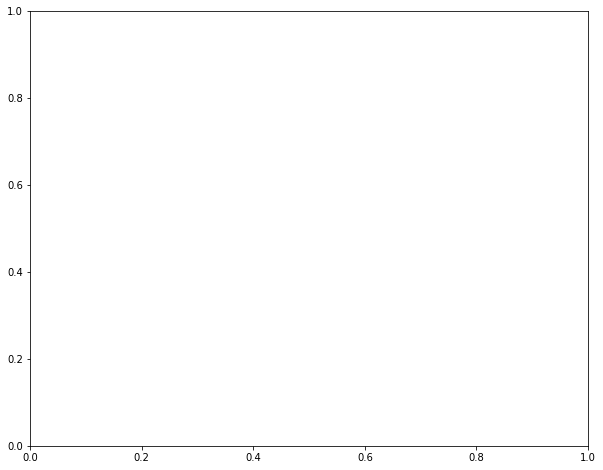

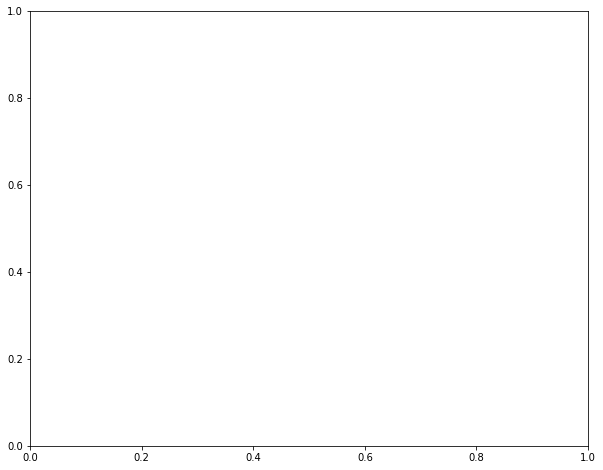

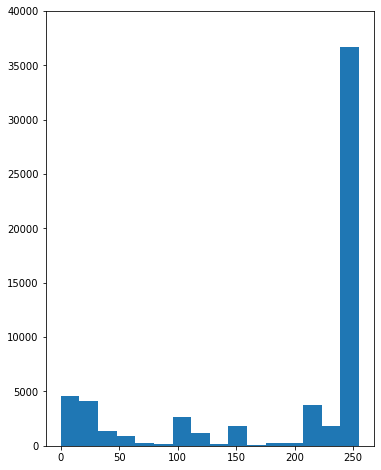

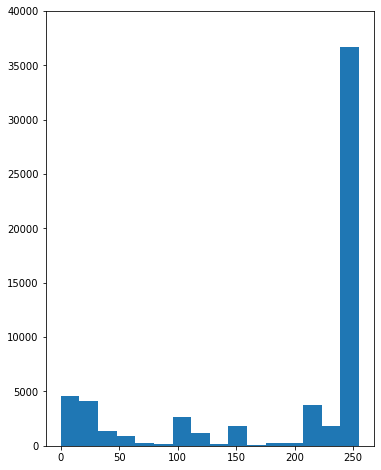

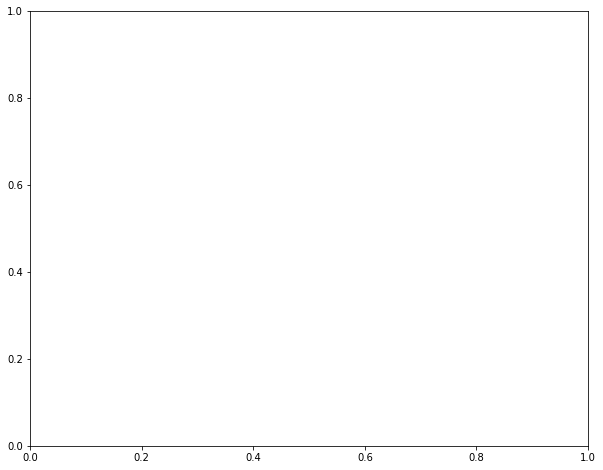

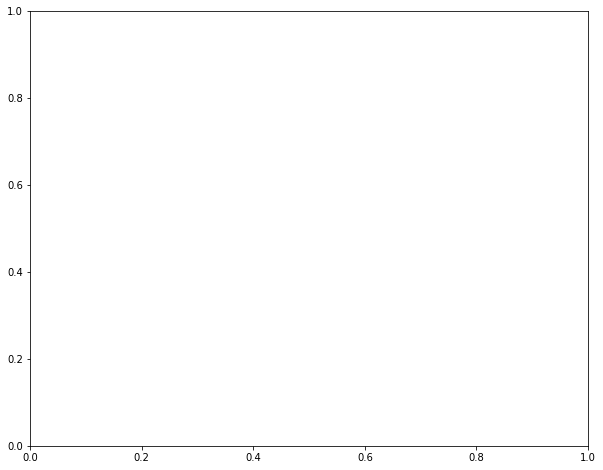

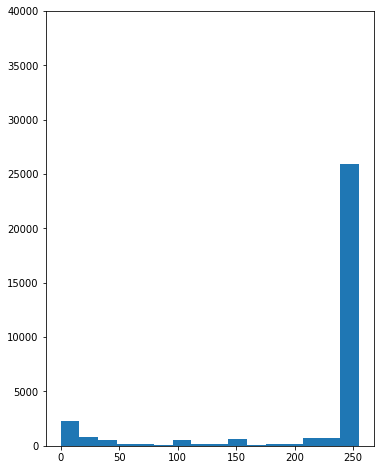

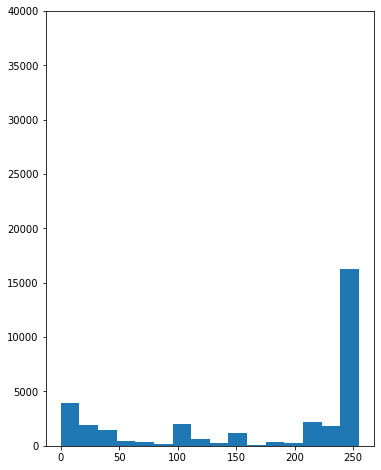

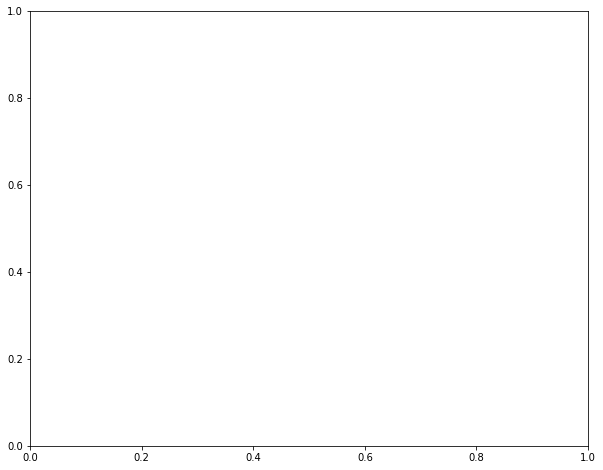

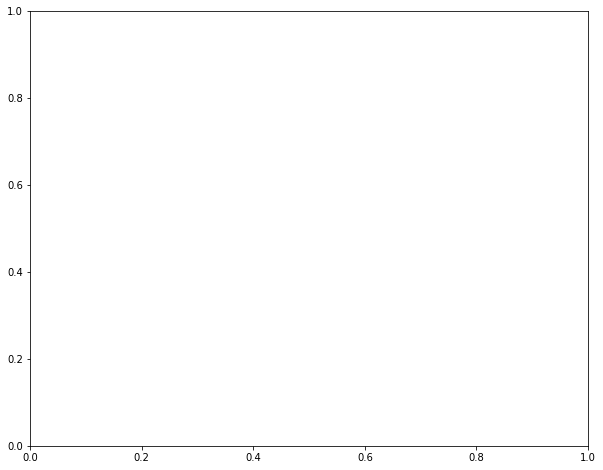

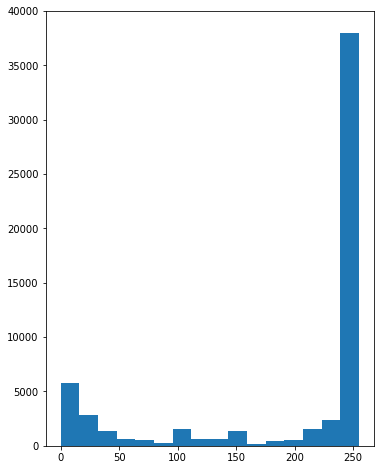

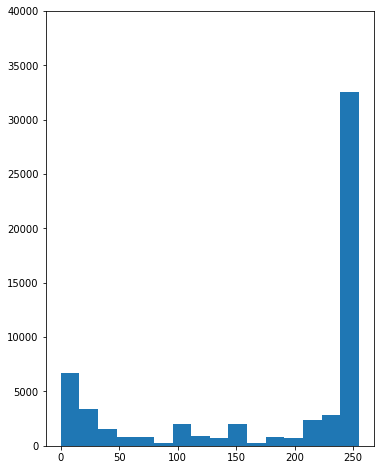

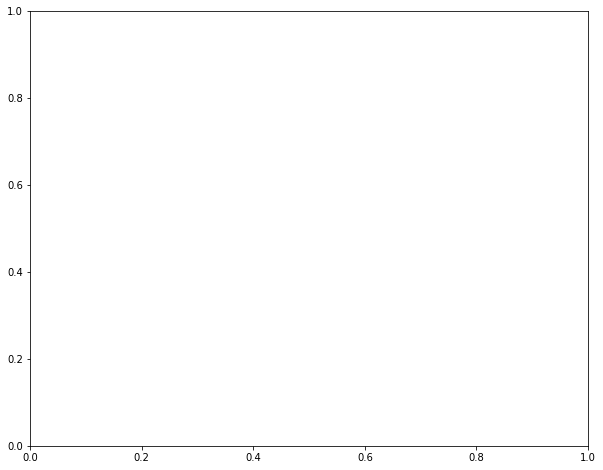

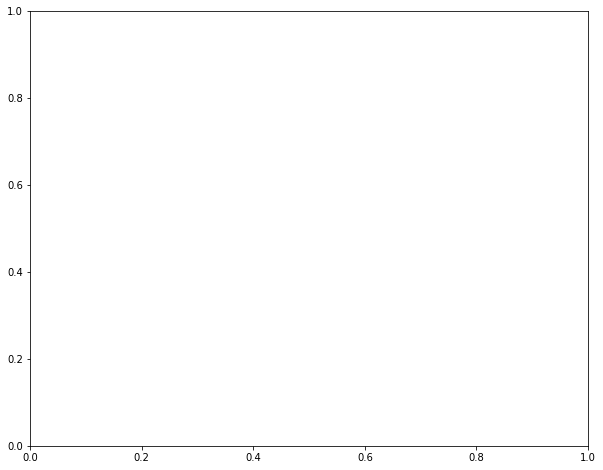

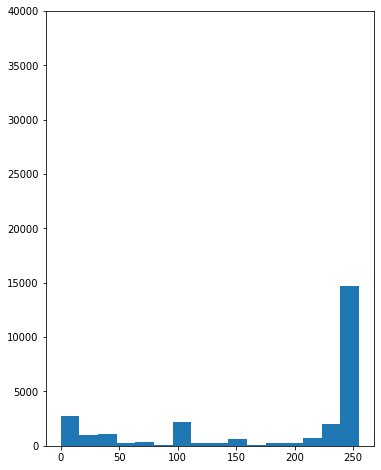

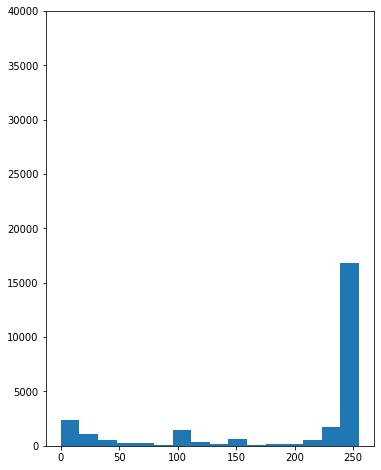

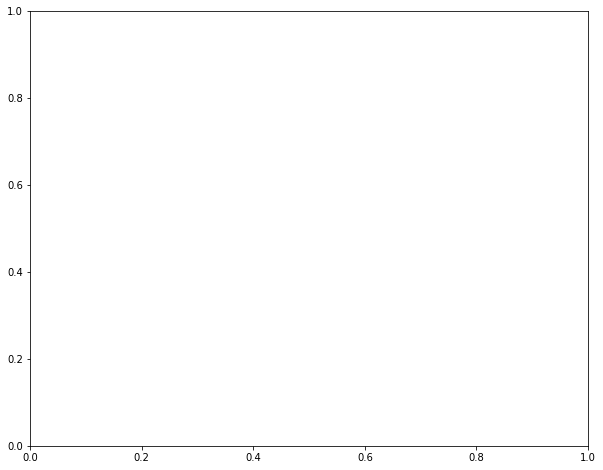

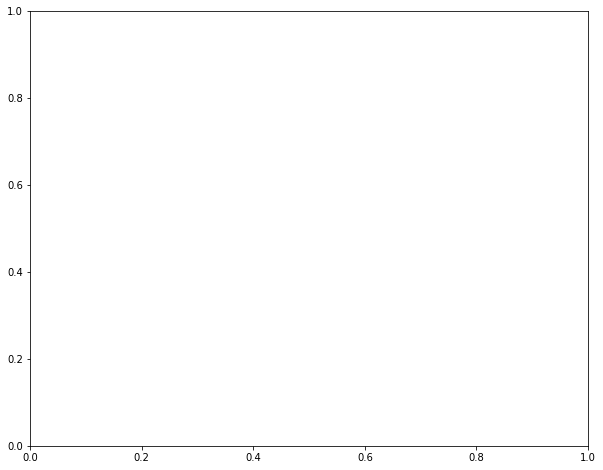

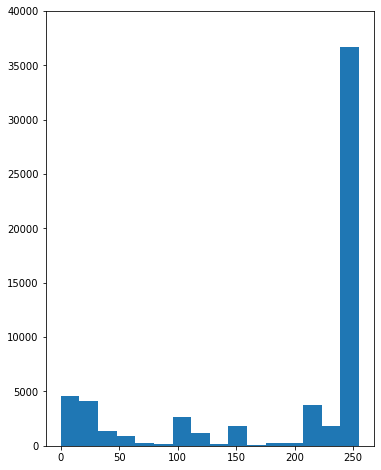

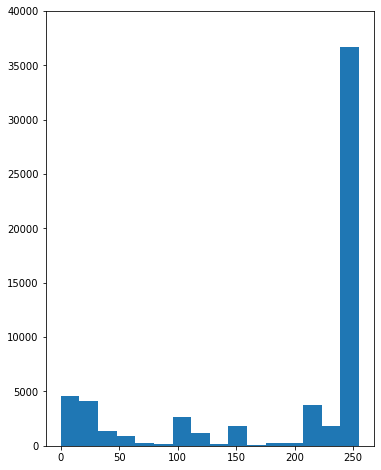

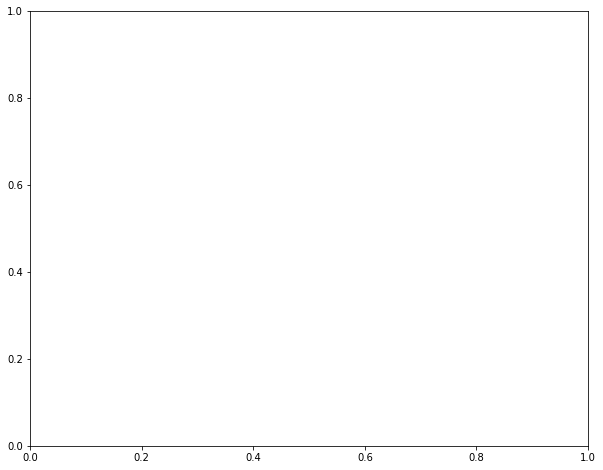

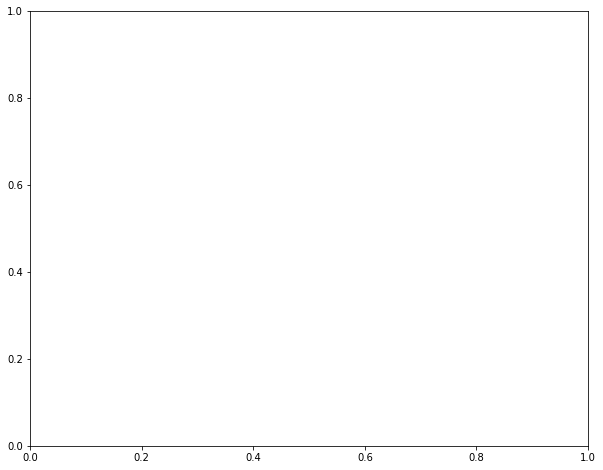

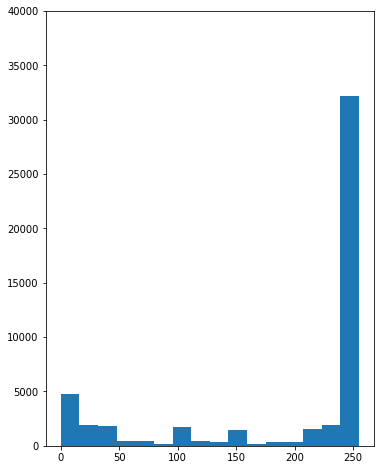

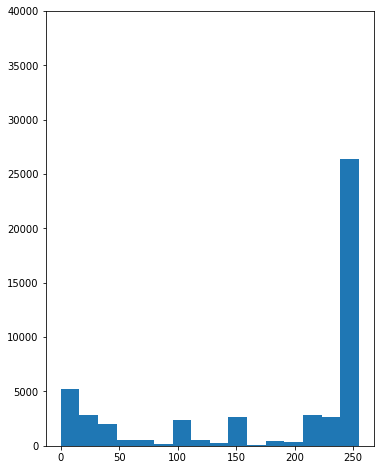

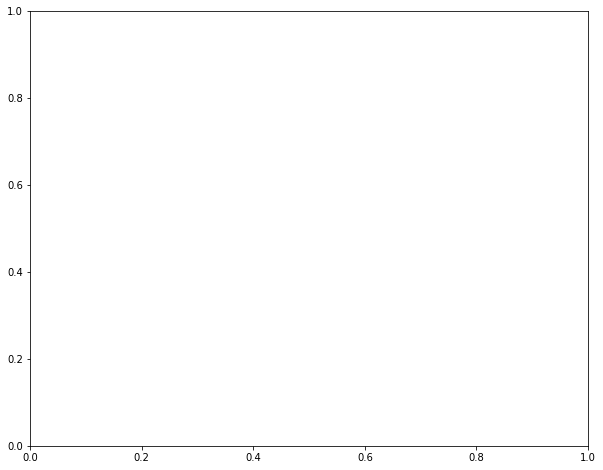

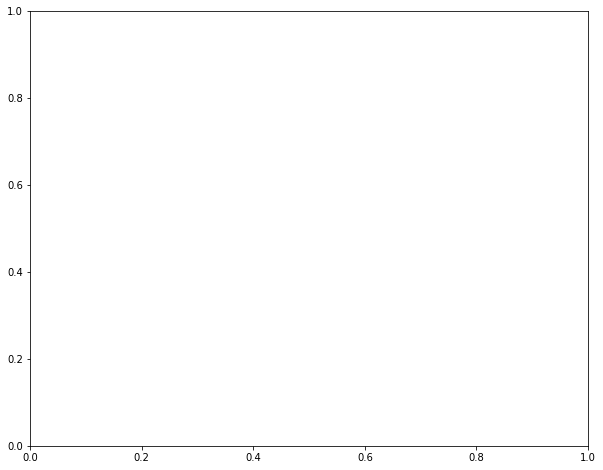

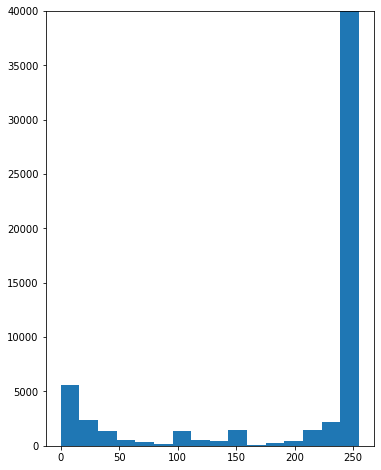

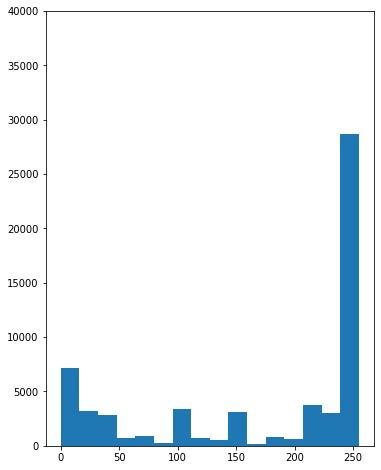

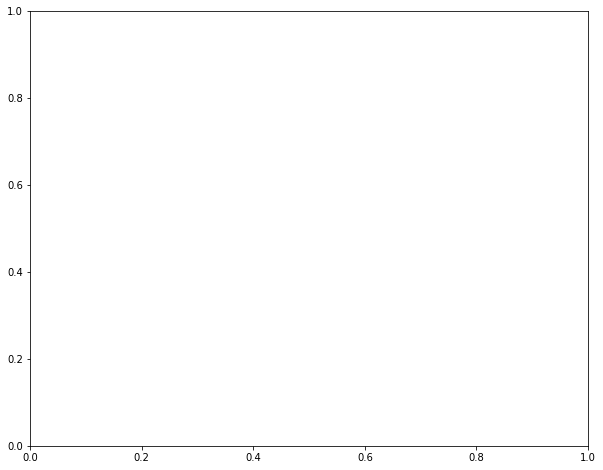

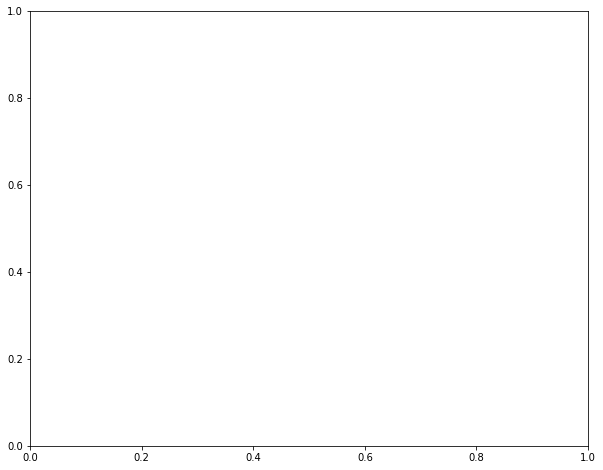

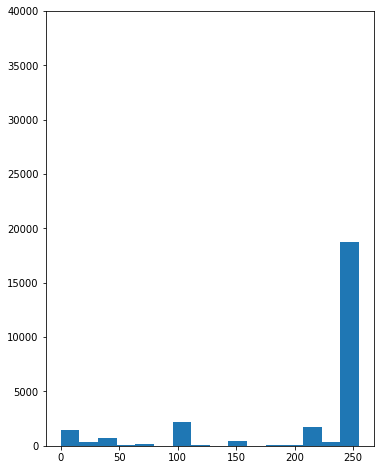

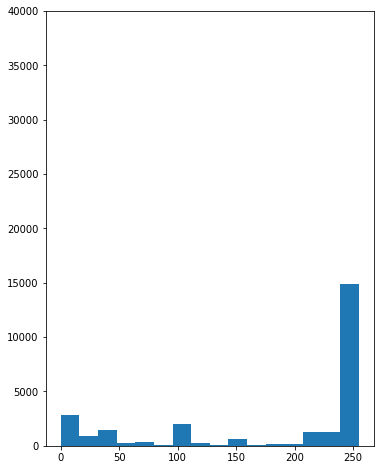

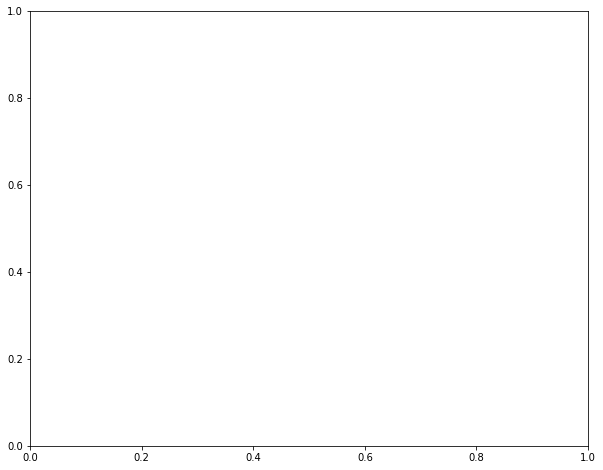

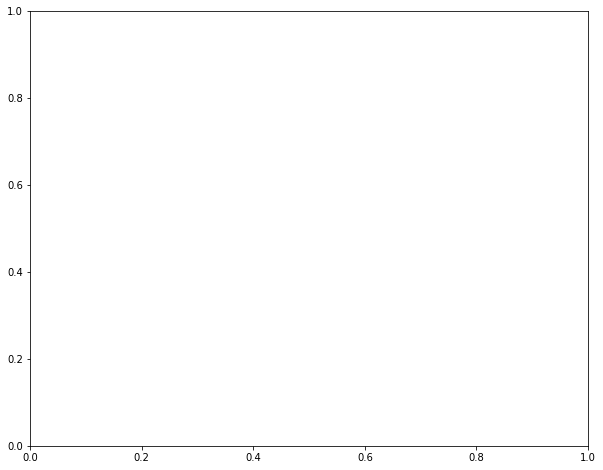

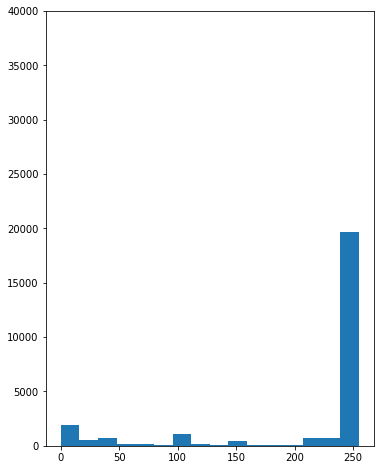

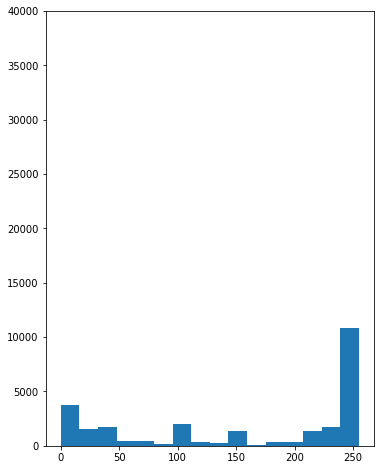

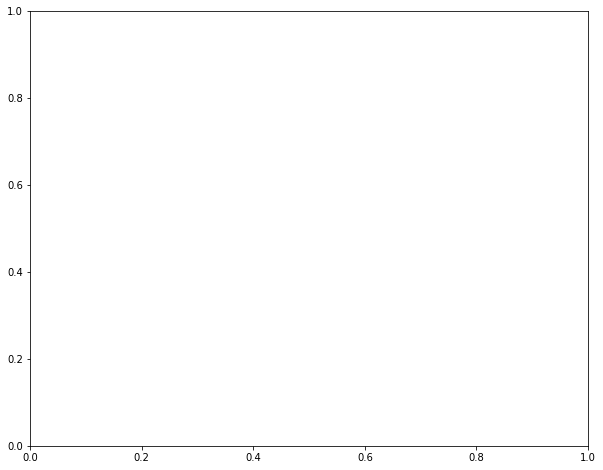

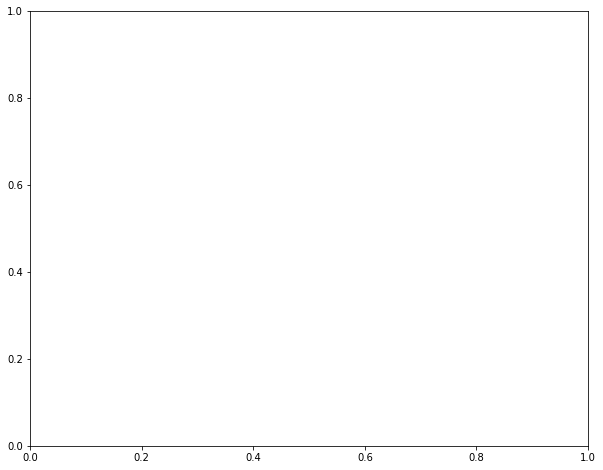

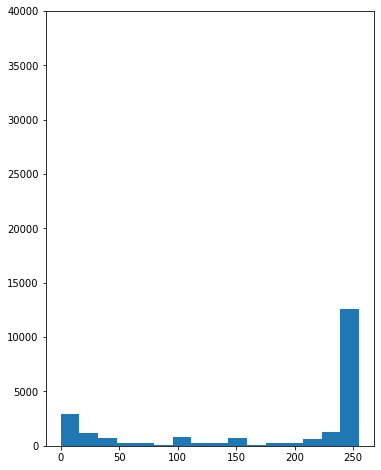

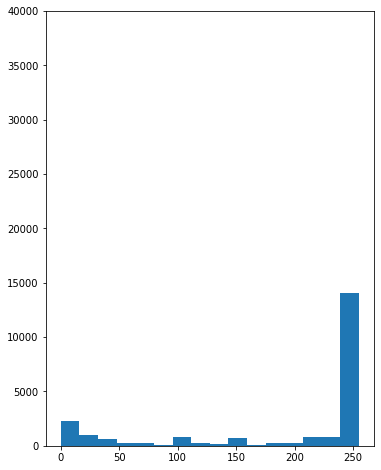

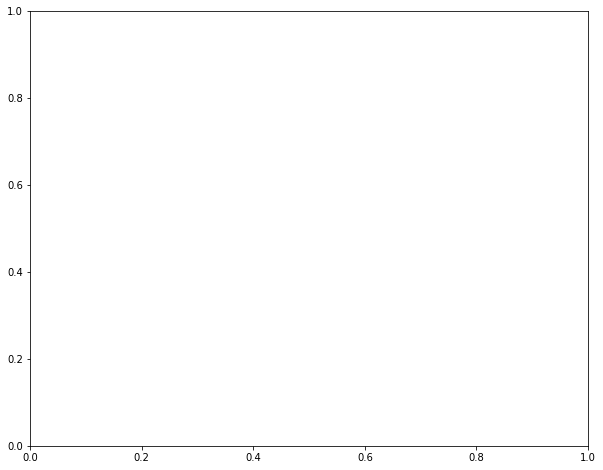

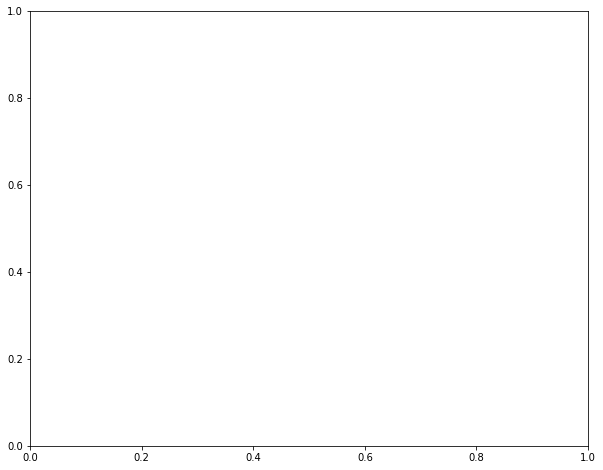

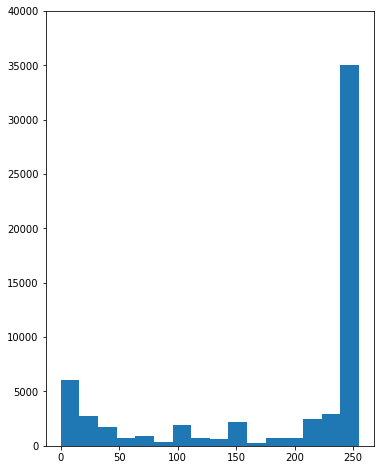

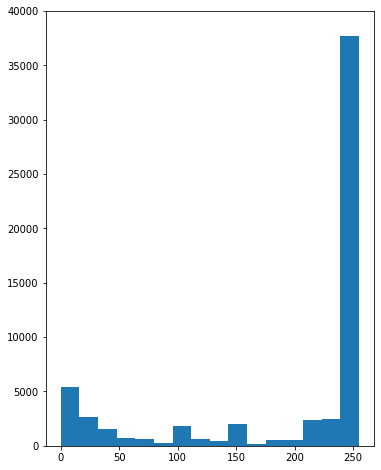

In [140]:
from PIL import Image
imgPath_feature = []
img_path_obj = []
distancesset=[]
imageCount = 10
query="lion"
fq,bq,imgq= get_image(query)
Hq=smfm(fq,bq)
for x in range(imageCount):
  fi,bi,imgi= get_image(query) 
  Hi=smfm(fi,bi) 
  distancesset.append(chi2_distance(Hq,Hi))
  imgPath_feature.append([imgi,chi2_distance(Hq,Hi)])
  img_path_obj.append(imgi)

mean = np.mean(distancesset)
std = np.std(distancesset)

#z-score normalization
finalDistances=[]
for x in distancesset: 
  finalDistances.append(((x-mean)/std))
 
ids = np.argsort(finalDistances)

scores = [(finalDistances[id], imgPath_feature[id]) for id in ids]


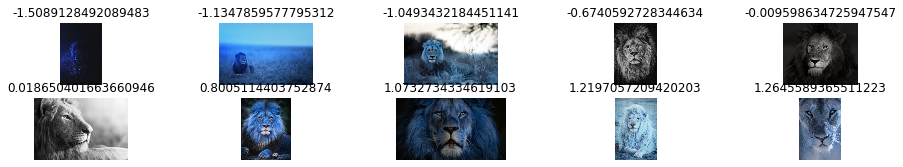

In [146]:
# Visualize the result
axes=[]
fig=plt.figure(figsize=(16,8))  
for image1 in range(imageCount):
    axes.append(fig.add_subplot(6, 5, image1+1))
    subplot_title=str(scores[image1][0])
    axes[image1].set_title(subplot_title)
    plt.axis('off')
    plt.imshow(scores[image1][1][0])